- 교재 :  <(파이토치 트랜스포머를 활용한) 자연어 처리와 컴퓨터 비전 심층학습>
- 범위 :  7. 트랜스포머 (p.357 ~ 387)

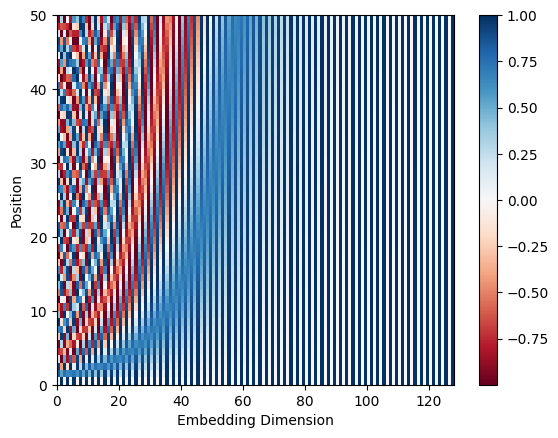

In [1]:
import math
import torch
from torch import nn
from matplotlib import pyplot as plt


class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len, dropout=0.1):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model)
        )

        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer("pe", pe)

    def forward(self, x):
        x = x + self.pe[: x.size(0)]
        return self.dropout(x)


encoding = PositionalEncoding(d_model=128, max_len=50)

plt.pcolormesh(encoding.pe.numpy().squeeze(), cmap="RdBu")
plt.xlabel("Embedding Dimension")
plt.xlim((0, 128))
plt.ylabel("Position")
plt.colorbar()
plt.show()

In [1]:
import urllib.request
import tarfile
import os

# 직접 데이터 다운로드
urls = {
    "train": "https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/Multi30k/training.tar.gz",
    "valid": "https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/Multi30k/validation.tar.gz",
    "test": "https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/Multi30k/mmt16_task1_test.tar.gz"
}

for split, url in urls.items():
    filename = f"{split}.tar.gz"
    urllib.request.urlretrieve(url, filename)

    # 압축 해제
    with tarfile.open(filename, 'r:gz') as tar:
        tar.extractall()

/tmp/ipython-input-884868834.py:18: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall()


In [2]:
import os
import torch
from collections import Counter
import re

def basic_tokenizer(text):
    text = text.lower()
    text = re.sub(r'([.!?,:;()])', r' \1 ', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip().split()

class Vocabulary:
    def __init__(self, special_symbols=None):
        if special_symbols is None:
            special_symbols = ["<unk>", "<pad>", "<bos>", "<eos>"]

        self.special_symbols = special_symbols
        self.vocab = {}
        self.idx_to_token = {}
        self.default_index = 0

        for i, symbol in enumerate(special_symbols):
            self.vocab[symbol] = i
            self.idx_to_token[i] = symbol

    def build_vocab(self, token_iterator, min_freq=1):
        counter = Counter()
        for tokens in token_iterator:
            counter.update(tokens)

        vocab_idx = len(self.special_symbols)
        for token, freq in counter.items():
            if freq >= min_freq and token not in self.vocab:
                self.vocab[token] = vocab_idx
                self.idx_to_token[vocab_idx] = token
                vocab_idx += 1

    def __call__(self, tokens):
        return [self.vocab.get(token, self.default_index) for token in tokens]

    def lookup_tokens(self, indices):
        return [self.idx_to_token.get(idx, self.special_symbols[0]) for idx in indices]

    def set_default_index(self, index):
        self.default_index = index

    def __len__(self):
        return len(self.vocab)

class CustomMulti30k:
    def __init__(self, split, language_pair=('de', 'en')):
        self.split = split
        self.src_lang, self.tgt_lang = language_pair
        self.data = self._load_data()

    def _load_data(self):
        file_mapping = {
            "train": ('train.de', 'train.en'),
            "valid": ('val.de', 'val.en'),
            "test": ('test.de', 'test.en')
        }

        src_file, tgt_file = file_mapping[self.split]
        data = []

        with open(src_file, 'r', encoding='utf-8') as f_src, \
             open(tgt_file, 'r', encoding='utf-8') as f_tgt:
            for src_line, tgt_line in zip(f_src, f_tgt):
                data.append((src_line.strip(), tgt_line.strip()))

        return data

    def __iter__(self):
        for item in self.data:
            yield item

    def __len__(self):
        return len(self.data)

def generate_tokens(text_iter, language, tokenizer_func):
    language_index = {SRC_LANGUAGE: 0, TGT_LANGUAGE: 1}

    for text in text_iter:
        tokens = tokenizer_func(text[language_index[language]])
        yield tokens

SRC_LANGUAGE = "de"
TGT_LANGUAGE = "en"
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
special_symbols = ["<unk>", "<pad>", "<bos>", "<eos>"]

token_transform = {
    SRC_LANGUAGE: basic_tokenizer,
    TGT_LANGUAGE: basic_tokenizer,
}

vocab_transform = {}
for language in [SRC_LANGUAGE, TGT_LANGUAGE]:
    train_iter = CustomMulti30k(split="train", language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    vocab_transform[language] = Vocabulary(special_symbols)
    token_generator = generate_tokens(train_iter, language, token_transform[language])
    vocab_transform[language].build_vocab(token_generator, min_freq=1)
    vocab_transform[language].set_default_index(UNK_IDX)

for language in [SRC_LANGUAGE, TGT_LANGUAGE]:
    vocab_transform[language].set_default_index(UNK_IDX)

print("Vocab Transform:")
print(vocab_transform)

Vocab Transform:
{'de': <__main__.Vocabulary object at 0x78bbcbf4f560>, 'en': <__main__.Vocabulary object at 0x78baf3f5f7a0>}


In [4]:
import math
import torch
from torch import nn

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len, dropout=0.1):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model)
        )
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer("pe", pe)

    def forward(self, x):
        x = x + self.pe[: x.size(0)]
        return self.dropout(x)

class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size, emb_size):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size

    def forward(self, tokens):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)

class Seq2SeqTransformer(nn.Module):
    def __init__(
        self,
        num_encoder_layers,
        num_decoder_layers,
        emb_size,
        max_len,
        nhead,
        src_vocab_size,
        tgt_vocab_size,
        dim_feedforward,
        dropout=0.1,
    ):
        super().__init__()
        self.src_tok_emb = TokenEmbedding(src_vocab_size, emb_size)
        self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, emb_size)
        self.positional_encoding = PositionalEncoding(
            d_model=emb_size, max_len=max_len, dropout=dropout
        )
        self.transformer = nn.Transformer(
            d_model=emb_size,
            nhead=nhead,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_decoder_layers,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
        )
        self.generator = nn.Linear(emb_size, tgt_vocab_size)

    def forward(
        self,
        src,
        trg,
        src_mask,
        tgt_mask,
        src_padding_mask,
        tgt_padding_mask,
        memory_key_padding_mask,
    ):
        src_emb = self.positional_encoding(self.src_tok_emb(src))
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(trg))
        outs = self.transformer(
            src=src_emb,
            tgt=tgt_emb,
            src_mask=src_mask,
            tgt_mask=tgt_mask,
            memory_mask=None,
            src_key_padding_mask=src_padding_mask,
            tgt_key_padding_mask=tgt_padding_mask,
            memory_key_padding_mask=memory_key_padding_mask
        )
        return self.generator(outs)

    def encode(self, src, src_mask):
        return self.transformer.encoder(
            self.positional_encoding(self.src_tok_emb(src)), src_mask
        )

    def decode(self, tgt, memory, tgt_mask):
        return self.transformer.decoder(
            self.positional_encoding(self.tgt_tok_emb(tgt)), memory, tgt_mask
        )

In [5]:
import os
import torch
from collections import Counter
import re

def basic_tokenizer(text):
    text = text.lower()
    text = re.sub(r'([.!?,:;()])', r' \1 ', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip().split()

class Vocabulary:
    def __init__(self, special_symbols=None):
        if special_symbols is None:
            special_symbols = ["<unk>", "<pad>", "<bos>", "<eos>"]

        self.special_symbols = special_symbols
        self.vocab = {}
        self.idx_to_token = {}
        self.default_index = 0

        for i, symbol in enumerate(special_symbols):
            self.vocab[symbol] = i
            self.idx_to_token[i] = symbol

    def build_vocab(self, token_iterator, min_freq=1):
        counter = Counter()
        for tokens in token_iterator:
            counter.update(tokens)

        vocab_idx = len(self.special_symbols)
        for token, freq in counter.items():
            if freq >= min_freq and token not in self.vocab:
                self.vocab[token] = vocab_idx
                self.idx_to_token[vocab_idx] = token
                vocab_idx += 1

    def __call__(self, tokens):
        return [self.vocab.get(token, self.default_index) for token in tokens]

    def lookup_tokens(self, indices):
        return [self.idx_to_token.get(idx, self.special_symbols[0]) for idx in indices]

    def set_default_index(self, index):
        self.default_index = index

    def __len__(self):
        return len(self.vocab)

class CustomMulti30k:
    def __init__(self, split, language_pair=('de', 'en')):
        self.split = split
        self.src_lang, self.tgt_lang = language_pair
        self.data = self._load_data()

    def _load_data(self):
        file_mapping = {
            "train": ('train.de', 'train.en'),
            "valid": ('val.de', 'val.en'),
            "test": ('test.de', 'test.en')
        }

        src_file, tgt_file = file_mapping[self.split]
        data = []

        with open(src_file, 'r', encoding='utf-8') as f_src, \
             open(tgt_file, 'r', encoding='utf-8') as f_tgt:
            for src_line, tgt_line in zip(f_src, f_tgt):
                data.append((src_line.strip(), tgt_line.strip()))

        return data

    def __iter__(self):
        for item in self.data:
            yield item

    def __len__(self):
        return len(self.data)

def generate_tokens(text_iter, language, tokenizer_func):
    language_index = {SRC_LANGUAGE: 0, TGT_LANGUAGE: 1}

    for text in text_iter:
        tokens = tokenizer_func(text[language_index[language]])
        yield tokens

SRC_LANGUAGE = "de"
TGT_LANGUAGE = "en"
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
special_symbols = ["<unk>", "<pad>", "<bos>", "<eos>"]

token_transform = {
    SRC_LANGUAGE: basic_tokenizer,
    TGT_LANGUAGE: basic_tokenizer,
}

vocab_transform = {}
for language in [SRC_LANGUAGE, TGT_LANGUAGE]:
    train_iter = CustomMulti30k(split="train", language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    vocab_transform[language] = Vocabulary(special_symbols)
    token_generator = generate_tokens(train_iter, language, token_transform[language])
    vocab_transform[language].build_vocab(token_generator, min_freq=1)
    vocab_transform[language].set_default_index(UNK_IDX)

from torch import optim

BATCH_SIZE = 128
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

model = Seq2SeqTransformer(
    num_encoder_layers=2,
    num_decoder_layers=2,
    emb_size=128,
    max_len=128,
    nhead=8,
    src_vocab_size=len(vocab_transform[SRC_LANGUAGE]),
    tgt_vocab_size=len(vocab_transform[TGT_LANGUAGE]),
    dim_feedforward=128,
).to(DEVICE)
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX).to(DEVICE)
optimizer = optim.Adam(model.parameters())

for main_name, main_module in model.named_children():
    print(main_name)
    for sub_name, sub_module in main_module.named_children():
        print("└", sub_name)
        for ssub_name, ssub_module in sub_module.named_children():
            print("│  └", ssub_name)
            for sssub_name, sssub_module in ssub_module.named_children():
                print("│  │  └", sssub_name)

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


src_tok_emb
└ embedding
tgt_tok_emb
└ embedding
positional_encoding
└ dropout
transformer
└ encoder
│  └ layers
│  │  └ 0
│  │  └ 1
│  └ norm
└ decoder
│  └ layers
│  │  └ 0
│  │  └ 1
│  └ norm
generator


In [7]:
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

class CustomMulti30kDataset:
    def __init__(self, split, language_pair=('de', 'en')):
        self.split = split
        self.src_lang, self.tgt_lang = language_pair
        self.data = self._load_data()

    def _load_data(self):
        file_mapping = {
            "train": ('train.de', 'train.en'),
            "valid": ('val.de', 'val.en'),
            "test": ('test.de', 'test.en')
        }

        src_file, tgt_file = file_mapping[self.split]
        data = []

        with open(src_file, 'r', encoding='utf-8') as f_src, \
             open(tgt_file, 'r', encoding='utf-8') as f_tgt:
            for src_line, tgt_line in zip(f_src, f_tgt):
                data.append((src_line.strip(), tgt_line.strip()))

        return data

    def __iter__(self):
        for item in self.data:
            yield item

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

def input_transform(token_ids):
    return torch.cat(
        (torch.tensor([BOS_IDX]), torch.tensor(token_ids), torch.tensor([EOS_IDX]))
    )

def collator(batch):
    src_batch, tgt_batch = [], []
    for src_sample, tgt_sample in batch:
        src_batch.append(text_transform[SRC_LANGUAGE](src_sample.rstrip("\n")))
        tgt_batch.append(text_transform[TGT_LANGUAGE](tgt_sample.rstrip("\n")))
    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
    tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX)
    return src_batch, tgt_batch

text_transform = {}
for language in [SRC_LANGUAGE, TGT_LANGUAGE]:
    text_transform[language] = sequential_transforms(
        token_transform[language], vocab_transform[language], input_transform
    )

data_iter = CustomMulti30kDataset(split="valid", language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
dataloader = DataLoader(data_iter, batch_size=BATCH_SIZE, collate_fn=collator)
source_tensor, target_tensor = next(iter(dataloader))

print("(source, target):")
sample_data = CustomMulti30kDataset(split="valid", language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
print(next(iter(sample_data)))

print("source_batch:", source_tensor.shape)
print(source_tensor)

print("target_batch:", target_tensor.shape)
print(target_tensor)

(source, target):
('Eine Gruppe von Männern lädt Baumwolle auf einen Lastwagen', 'A group of men are loading cotton onto a truck')
source_batch: torch.Size([35, 128])
tensor([[   2,    2,    2,  ...,    2,    2,    2],
        [  48,   21,   21,  ...,   21,    4,   21],
        [ 127,   29,    5,  ...,   29, 4279,   23],
        ...,
        [   1,    1,    1,  ...,    1,    1,    1],
        [   1,    1,    1,  ...,    1,    1,    1],
        [   1,    1,    1,  ...,    1,    1,    1]])
target_batch: torch.Size([30, 128])
tensor([[   2,    2,    2,  ...,    2,    2,    2],
        [  21,   21,   21,  ...,   86,    4,   21],
        [ 249,   31,  241,  ...,   31, 2964,   25],
        ...,
        [   1,    1,    1,  ...,    1,    1,    1],
        [   1,    1,    1,  ...,    1,    1,    1],
        [   1,    1,    1,  ...,    1,    1,    1]])


In [8]:
def generate_square_subsequent_mask(s):
    mask = (torch.triu(torch.ones((s, s), device=DEVICE)) == 1).transpose(0, 1)
    mask = (
        mask.float()
        .masked_fill(mask == 0, float("-inf"))
        .masked_fill(mask == 1, float(0.0))
    )
    return mask


def create_mask(src, tgt):
    src_seq_len = src.shape[0]
    tgt_seq_len = tgt.shape[0]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    src_mask = torch.zeros((src_seq_len, src_seq_len), device=DEVICE).type(torch.bool)

    src_padding_mask = (src == PAD_IDX).transpose(0, 1)
    tgt_padding_mask = (tgt == PAD_IDX).transpose(0, 1)
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask


target_input = target_tensor[:-1, :]
target_out = target_tensor[1:, :]

source_mask, target_mask, source_padding_mask, target_padding_mask = create_mask(
    source_tensor, target_input
)

print("source_mask:", source_mask.shape)
print(source_mask)
print("target_mask:", target_mask.shape)
print(target_mask)
print("source_padding_mask:", source_padding_mask.shape)
print(source_padding_mask)
print("target_padding_mask:", target_padding_mask.shape)
print(target_padding_mask)

source_mask: torch.Size([35, 35])
tensor([[False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        ...,
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False]], device='cuda:0')
target_mask: torch.Size([29, 29])
tensor([[0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf,
         -inf, -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf,
         -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf,
         -inf, -inf, -inf,

In [9]:
def run(model, optimizer, criterion, split):
    model.train() if split == "train" else model.eval()
    data_iter = CustomMulti30kDataset(split=split, language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    dataloader = DataLoader(data_iter, batch_size=BATCH_SIZE, collate_fn=collator)

    losses = 0
    for source_batch, target_batch in dataloader:
        source_batch = source_batch.to(DEVICE)
        target_batch = target_batch.to(DEVICE)

        target_input = target_batch[:-1, :]
        target_output = target_batch[1:, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(
            source_batch, target_input
        )

        logits = model(
            src=source_batch,
            trg=target_input,
            src_mask=src_mask,
            tgt_mask=tgt_mask,
            src_padding_mask=src_padding_mask,
            tgt_padding_mask=tgt_padding_mask,
            memory_key_padding_mask=src_padding_mask,
        )

        optimizer.zero_grad()
        loss = criterion(logits.reshape(-1, logits.shape[-1]), target_output.reshape(-1))
        if split == "train":
            loss.backward()
            optimizer.step()
        losses += loss.item()

    return losses / len(list(dataloader))


for epoch in range(5):
    train_loss = run(model, optimizer, criterion, "train")
    val_loss = run(model, optimizer, criterion, "valid")
    print(f"Epoch: {epoch+1}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}")

/usr/local/lib/python3.12/dist-packages/torch/nn/functional.py:6041: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch: 1, Train loss: 4.772, Val loss: 3.872
Epoch: 2, Train loss: 3.688, Val loss: 3.414
Epoch: 3, Train loss: 3.306, Val loss: 3.165
Epoch: 4, Train loss: 3.053, Val loss: 2.996
Epoch: 5, Train loss: 2.852, Val loss: 2.876


In [10]:
def greedy_decode(model, source_tensor, source_mask, max_len, start_symbol):
    source_tensor = source_tensor.to(DEVICE)
    source_mask = source_mask.to(DEVICE)

    memory = model.encode(source_tensor, source_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(DEVICE)
    for i in range(max_len - 1):
        memory = memory.to(DEVICE)
        target_mask = generate_square_subsequent_mask(ys.size(0))
        target_mask = target_mask.type(torch.bool).to(DEVICE)

        out = model.decode(ys, memory, target_mask)
        out = out.transpose(0, 1)
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.item()

        ys = torch.cat(
            [ys, torch.ones(1, 1).type_as(source_tensor.data).fill_(next_word)], dim=0
        )
        if next_word == EOS_IDX:
            break
    return ys


def translate(model, source_sentence):
    model.eval()
    source_tensor = text_transform[SRC_LANGUAGE](source_sentence).view(-1, 1)
    num_tokens = source_tensor.shape[0]
    src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
    tgt_tokens = greedy_decode(
        model, source_tensor, src_mask, max_len=num_tokens + 5, start_symbol=BOS_IDX
    ).flatten()
    output = vocab_transform[TGT_LANGUAGE].lookup_tokens(list(tgt_tokens.cpu().numpy()))[1:-1]
    return " ".join(output)


output_oov = translate(model, "Eine Gruppe von Menschen steht vor einem Iglu .")
output = translate(model, "Eine Gruppe von Menschen steht vor einem Gebäude .")
print(output_oov)
print(output)

a group of people standing in front of a group of a crowd .
a group of people standing outside a building .
